# Implementation
In this section, we will solve the deflection of the membrane problem, as well as learning how to create meshes with GMSH and how to use Paraview to visualize the solution.

## Creating the mesh
Author: Jørgen S. Dokken

To create the computational geometry, we use the python-API of [GMSH](http://gmsh.info/). We start by import the gmsh-module, and initalizing it.

In [1]:
import gmsh
gmsh.initialize()

The next step is to create the membrane and starting the computations by the GMSH CAD kernel, to generate the relevant underlying data structures. The arguments into `addDisk` is the x, y and z coordinate of the center of the circle, while the to last argument is the x-radius and y-radius.

In [2]:
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()

The next step is to make the membrane a physical surface, such that it is recognized by gmsh when generating the mesh. As a surface is a two-dimensional entity, we add two as the first argument, and the entity tag of the as the second argument. The last argument is the physical tag. In a later demo, we will get into when this tag matters.

In [3]:
gdim = 2
status = gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

Finally, we generate the two-dimensional mesh. We set a uniform mesh size by modifying the GMSH options

In [4]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)
gmsh.model.mesh.generate(gdim)

We will import the GMSH-mesh directly from GMSH, using the approach in Section 2 of [A GMSH tutorial for dolfinx](http://jsdokken.com/converted_files/tutorial_gmsh.html). To make sure this runs in parallel and  serial, we will read in the mesh on one processor, and let dolfin-X distribute the mesh data among the processros.

In [5]:
from dolfinx.io import extract_gmsh_geometry,extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh
from mpi4py import MPI
from warnings import filterwarnings

filterwarnings("ignore")
if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    geometry_data = extract_gmsh_geometry(gmsh.model)
    # Get mesh topology for each element
    topology_data = extract_gmsh_topology_and_markers(gmsh.model)

The topology data is a dictionary, where the key is the gmsh cell type (an integer). Each key accesses a dictionary with the topology data and corresponding topology markers. As this mesh only contains one cell type (triangles), as we did not mark any facets, we do not need to loop over the keys of this dictionary, only extract the first one.

In [6]:
import numpy as np
if MPI.COMM_WORLD.rank == 0:
    # Extract the cell type and number of nodes per cell and broadcast
    # it to the other processors 
    gmsh_cell_type = list(topology_data.keys())[0]    
    properties = gmsh.model.mesh.getElementProperties(gmsh_cell_type)
    name, dim, order, num_nodes, local_coords, _ = properties
    cells = topology_data[gmsh_cell_type]["topology"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([gmsh_cell_type, num_nodes], root=0)
else:        
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, geometry_data = np.empty([0, num_nodes]), np.empty([0, gdim])

As we have now broadcasted all the information required to distribute the mesh in parallel

In [7]:
from dolfinx.cpp.io import perm_gmsh
from dolfinx.cpp.mesh import to_type
from dolfinx.mesh import create_mesh

# Permute topology data from MSH-ordering to dolfinx-ordering
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]

# Create distributed mesh
mesh = create_mesh(MPI.COMM_WORLD, cells, geometry_data[:, :gdim], ufl_domain)


We define the function space as in the previous tutorial

In [8]:
import dolfinx
from petsc4py import PETSc
V = dolfinx.FunctionSpace(mesh, ("CG", 1))

## Defining the load
Authors: Hans Petter Langtangen and Anders Logg.

Adapted to dolfin-X: Jørgen S. Dokken

The right hand side pressure function is represented using 
Python-classes. The class will have an initializer, where we store the two physical parameters, and an evaluation function which has a physical coordinate `x` as input.

In [9]:
class Pressure():
    def __init__(self, beta, R0):
        self.beta = beta
        self.R0 = R0
    def __call__(self, x):
        return 4*np.exp(-self.beta**2*(x[0]**2+(x[1]-self.R0)**2))
pressure = Pressure(8, 0.6)

## Interpolation of the pressure
To be able to use this class in a variational formulation, we interpolate this function into the appropriate function space. In this case, we will use the same function space as we use for our approximate solution. An interpolation uses that any finite element function can be written as $p=\sum_{j=1}^N P_j\phi_j$, where we set $P_j=p(x_j, y_j)$ where $(x_j,y_j)$ are the coordinates of the node number $j$.

In [10]:
p = dolfinx.Function(V)
p.interpolate(pressure)
p.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)


We can modify the parameters at any time by changing the `pressure`-variables and update the interpolation, as follows

In [11]:
pressure.beta = 12
pressure.R0 = 0.3
p.interpolate(pressure)
p.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

We create the homogenuous boundary condition over the whole boundary which we do as in the first tutorial.

In [12]:
uD = dolfinx.Function(V)
uD.vector.set(0)
fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: np.full(x.shape[1], True, dtype=np.bool))
bc = dolfinx.DirichletBC(uD, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

## Defining the variational problem
The variational problem is the same as in our first Poisson problem, where `f` is replaced by `p`.

In [13]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = p * v * ufl.dx
problem = dolfinx.fem.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Plotting the solution over a line
We first plot the load and deflection with matplotlib


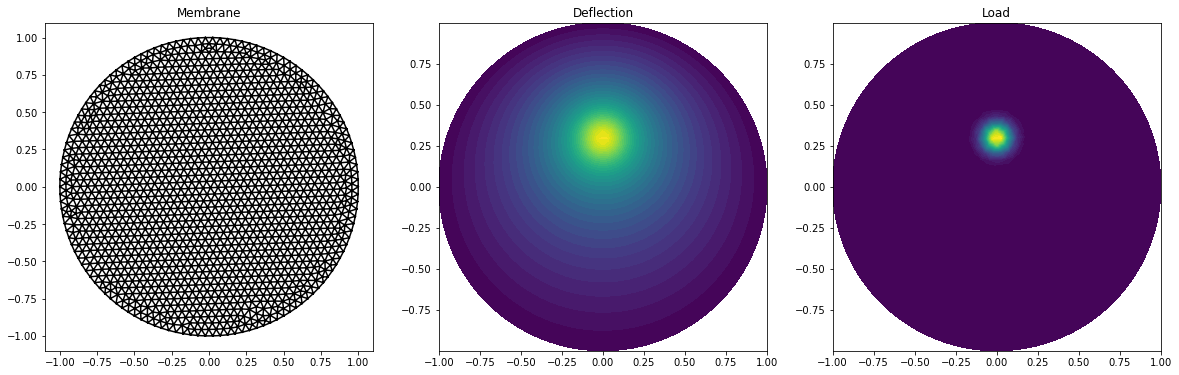

In [14]:
import matplotlib.pyplot as plt
import dolfinx.plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,60))
# Select first subfigure
plt.sca(ax1)
dolfinx.plotting.plot(mesh, title="Membrane", color="k")
# Select second subfigure 
plt.sca(ax2)
dolfinx.plotting.plot(uh, title="Deflection")
# Select third subfigure
plt.sca(ax3)
dolfinx.plotting.plot(p, title="Load")


## Making curve plots throughout the domain
Another way to compare the deflection and the load is to make a plot along the line $x=0$. This is just a matter of defining a set of points along the $y$-axis and evaluating the finite element functions $u$ and $p$ at these points. As we would like our code to run in parallel, where the mesh is distributed over multiple processors, we need some additional checks. As every point is not guaranteed to be found on each processor, we loop through the points and only evaluate our functions for those that has the point inside a cell owned by the processor.

In [15]:
import dolfinx.geometry
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []
p_values = []
bb_tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.topology.dim)
cells = []
points_on_proc = []
for point in points.T:
    # Find cells that are close to the point
    cell_candidates = dolfinx.geometry.compute_collisions_point(bb_tree, point)
    # Choose one of the cells that contains the point
    cell = dolfinx.cpp.geometry.select_colliding_cells(mesh, cell_candidates, point, 1)
    # Only search for points on current processor
    if len(cell) == 1:
        points_on_proc.append(point)
        cells.append(cell[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = p.eval(points_on_proc, cells)



As we now have an array of coordinates and two arrays of function values, we use matplotlib to plot them

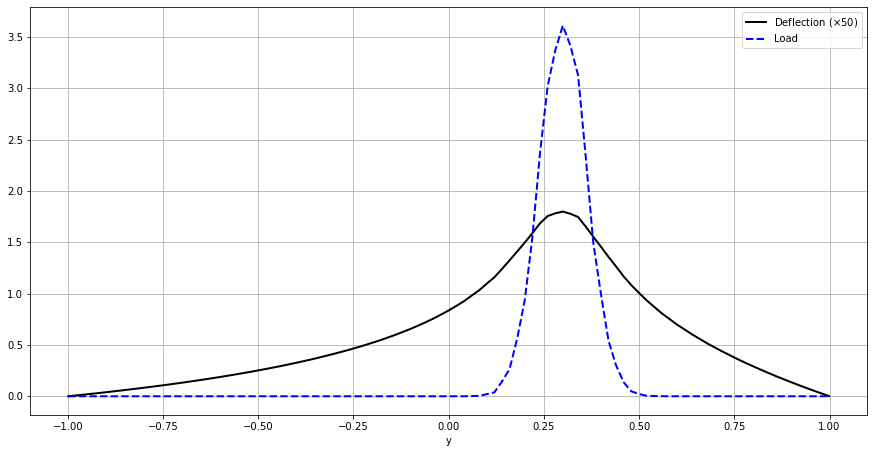

In [16]:
fig = plt.figure(figsize=(15,7.5))
plt.plot(points_on_proc[:,1], 50*u_values, "k", linewidth=2, label="Deflection ($\\times 50$)") # Magnify w
plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth = 2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If ran in parallel as a python file, we save a plot per processor
plt.savefig("membrane_rank{0:d}.png".format(MPI.COMM_WORLD.rank))

## Saving functions to file
As mentioned in the previous section, we can also use Paraview to visualize the solution.

In [17]:
import dolfinx.io
p.name = "Load"
uh.name = "Deflection"
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "results_membrane.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(p)
    xdmf.write_function(uh)